In [8]:
from typing import List, Dict, Tuple
from tqdm.auto import tqdm
import random
import os
import json
import re
from re import finditer
from itertools import tee
import pickle
import urllib
from collections.abc import Iterable, Iterator
from collections import defaultdict
from itertools import product

### Utils

def g_path(*argv: str)->str:
    """short hand for creating a new path properly
    args:
        argv: vector of strings to join into a path"""
    return os.path.join(*argv)

def pairwise(iterable:Iterable)->Iterator:
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def camel_case_split(identifier):
    matches = finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]


In [9]:
simulation_output_folder = "../simulations/"

vocab = json.load(open("data/vocab.json"))
topics = {x['title']:k for k,x in vocab.items() if x['title'] != "Sports" and x['title']!="Norepinephrine" and x['title']!="Research in lithium-ion batteries"}

subtopics = json.load(open("data/topics.json"))
subtopics = {x['title'] :x['terms'] for x in subtopics.values() if x['title'] != "Sports" and x['title']!="Norepinephrine" and x['title']!="Research in lithium-ion batteries"}
subtopics["Ethics"]["Meta-ethics"] = subtopics["Ethics"].pop("Meta ethics")

subtopics ={k: list(map(lambda x: urllib.parse.quote(x) , v.keys())) for k, v in subtopics.items()}  # Dict[topic_name, List[subtopic]] , Dict[str, List[str]]
subtopics_keywords = pickle.load(open("data/subtopic_l2_keywords.pkl", 'rb'))  # Dict[subtopic, Set[keywords]], Dict[str, Set[str]]

methods = {x.split("_")[0] for x in os.listdir(simulation_output_folder) if x!="COMPLETED"}

params = {"lambda": [0.1, 0.4, 0.8],
          "limit": [2.0, 6.0, 10.0],
          "threshold":[0.0, 1.0, 3.0, 5.0]
         }

all_users = list(product(params['limit'], params['threshold'], params['lambda']))


In [10]:
#Mappings
topics = {
    "ethics": 1,
    "genetically_modified_organism": 2,
    "noise-induced_hearing_loss": 3,
    "subprime_mortgage_crisis": 4,
    "radiocarbon_dating_considerations": 5,
    "business_cycle": 7,
    "irritable_bowel_syndrome": 8,
    "theory_of_mind": 9
}

subtopic_strategies = {
    "Greedy": 1,
    "Random": 2,
    "Reverse": 3,
    "GreedySmart":4
}

Parameters:
- `Sub` - Subtopic Decision Strategy
    - `vars`:
        - `l`: limit for subtopic Decision strategy
- `q`: Querying Strategy [FIXED at `q13`]
- `ss` Stoping Strategy [FIXED at `ss1`]
- `se`: SERP Impression [FIXED at `se0`]
- `sn`: Snippet Decision maker [FIXED at `sn0`]
    -`vars`:
        - `t`: threshold for relevance of snippet
        - `l`: Lambda for Language Model
- `doc` Document relevance decision maker [FIXED at doc0]
    - `vars`:
        - `l`: Lambda for Language Models
        
 Everything is repeated on the file name
   

In [11]:
#THIS IS LONG AF
HOME_PATH = "data/simulation_data"


def get_file_name(subtopic_strategy, limit, sn_threshold, sn_lambda,doc_lambda, topic, extension, run_id):
    limit = f"{str(limit).replace('.', '')}"
    sn_threshold = f"{str(sn_threshold).replace('.', '')}"
    sn_lambda = f"{str(sn_lambda).replace('.', '')}"
    doc_lambda = f"{str(doc_lambda).replace('.', '')}"

    partial_filename = f"run_{run_id}_sub{subtopic_strategy}-l{limit}_q13_ss1_se0_sn0-t{sn_threshold}l{sn_lambda}_doc0-l{doc_lambda}"
    run_file_template = f"{HOME_PATH}/run_{run_id}_sub{subtopic_strategy}/vars-l{limit}/q13/ss1/se0/sn0/vars-t{sn_threshold}l{sn_lambda}/doc0/vars-l{doc_lambda}/output/{partial_filename}-{topic}-user-{partial_filename}.{extension}"

    return run_file_template


#Sanity check
a = get_file_name(1, 10.0, 5.0, 0.8, 0.1, "ethics", "log",1)
print(a)
os.path.isfile(a)

data/simulation_data/run_1_sub1/vars-l100/q13/ss1/se0/sn0/vars-t50l08/doc0/vars-l01/output/run_1_sub1-l100_q13_ss1_se0_sn0-t50l08_doc0-l01-ethics-user-run_1_sub1-l100_q13_ss1_se0_sn0-t50l08_doc0-l01.log


True

In [12]:
#Take the weight of each topic, according to the number of subtopics
number_of_keywords_per_topic = dict()
for topic in subtopics.keys():
    encoded_topic_name = urllib.parse.quote(topic)
    topic_subtopics = ["/".join((encoded_topic_name, x)) for x in subtopics[topic]]
    all_keywords = set.union(*[subtopics_keywords[v] for v in topic_subtopics if v in subtopics_keywords])
    number_of_keywords_per_topic[topic] = len(all_keywords)

max_subtopic_keywords = max(number_of_keywords_per_topic.values())
normalization_factors = {k:v/max_subtopic_keywords for (k, v) in number_of_keywords_per_topic.items()}

In [15]:
params = {"lambda": [0.1, 0.4, 0.8],
          "limit": [2.0, 6.0, 10.0],
          "threshold":[0.0, 1.0, 3.0, 5.0],
          "topic":subtopics.keys(),
          "method":subtopic_strategies.keys()}
          

all_users_full = list(product(params['limit'], params['threshold'], params['lambda'], params["topic"], params["method"]))
doc_lambda= 0.1 #FIXED

docs_per_query_per_user = defaultdict(lambda:defaultdict(lambda:10*[0]))

for idx, (limit, threshold, lam, topic, method) in tqdm(enumerate(all_users_full), total=len(all_users_full)):
    u_id = f"{limit}-{threshold}-{lam}-{topic}-{method}"
    for r in range(10):
        logs = get_file_name(subtopic_strategies[method], limit, threshold, lam, doc_lambda, topic.lower().replace(" ", "_"), "log", r)
        query_no = -1
        for line in open(logs):
            action_name = line.split()[1]
            if action_name == "QUERY":
                query_no +=1
            elif action_name == "DOC":
                docs_per_query_per_user[u_id][query_no][r]+=1

In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.porter import *
stemmer = PorterStemmer()


stop_words = set(stopwords.words("english"))
pattern = re.compile("([^\s\w]|_)+")

# We use redis to speedup loading of documents already seen. Alternativelly, fetch the URL and parse the HTML.
import redis
db_url = redis.Redis(db=10, decode_responses=True)
def get_document_content(doc_url):
    if doc_url in db_url:
        return db_url.get(doc_url)
    return ""

def get_doc_keywords(doc, keywords):
    doc = get_document_content(doc)
    clean_doc = pattern.sub(" ", doc)
    clean_doc = [stemmer.stem(w.lower()) for w in clean_doc.split() if (w not in stop_words and stemmer.stem(w) in keywords)]
    return Counter(clean_doc)


In [17]:
# Local cache of urls. Faster than going to redis all the time
local_cache = dict()

In [18]:
def rebuild_lm_for_docs(file_name, keywords, topic, min_count = 5):
    lm = Counter()
    keywords_per_doc = []
    for idx, line in enumerate(open(file_name)):
        try:
            action = line.split()[1]
        except:
            continue
        if action == "DOC":
            url = line.split()[-1]
            try:
                doc_keywords = local_cache[(url, topic)]
            except KeyError:
                doc_keywords = get_doc_keywords(url, keywords)
                local_cache[(url, topic)] = doc_keywords
            #after this document, how many keywords were added?
            lm.update(doc_keywords)
            valid_keywords = [k for k,v in lm.items() if v > min_count]
            keywords_per_doc.append(len(valid_keywords)/len(keywords))
    return keywords_per_doc


def percentage_of_keywords_per_doc(limit, lam, threshold, topic, method,  n_runs):
    method_id = subtopic_strategies[method]
    c_topic =  topic.lower().replace(" ", "_")
    encoded_topic_name = urllib.parse.quote(topic)
    topic_subtopics = ["/".join((encoded_topic_name, x)) for x in subtopics[topic]]
    all_keywords = set.union(*[subtopics_keywords[v] for v in topic_subtopics if v in subtopics_keywords])
    all_runs = []
    for r in range(n_runs):
        file_name = get_file_name(method_id, limit, threshold, lam, doc_lambda, c_topic, "log", r)
        all_runs.append(rebuild_lm_for_docs(file_name, all_keywords, topic))
    #pad if needed
    longest_value = max([len(x) for x in all_runs])
    for i in range(n_runs):
        if len(all_runs[i]) < longest_value:
            last_value = all_runs[i][-1]
            all_runs[i].extend([last_value] * (longest_value - len(all_runs[i])))
    # get the mean over all runs
    mean_ys = []
    for i in range(max([len(x) for x in all_runs])):
        mean_ys.append(np.mean([x[i] for x in all_runs]))
    return mean_ys
# percentage_of_keywords_per_doc(limit, lam, threshold, topic, method,  10)


In [19]:
for method in all_ys:            
    longest_session = max(map(len, all_ys[method].values()))
    for topic in all_ys[method]:
        try:
            padding_needed = longest_session - len(all_ys[method][topic])
            padding = [all_ys[method][topic][-1]] * padding_needed
            all_ys[method][topic] += padding
        except:
            continue


NameError: name 'all_ys' is not defined

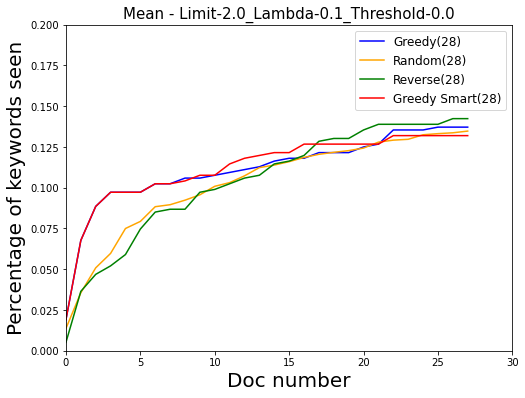

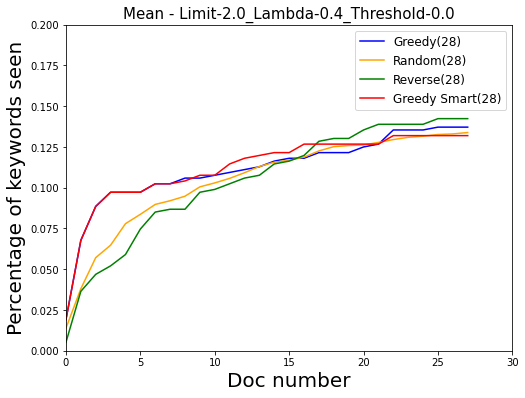

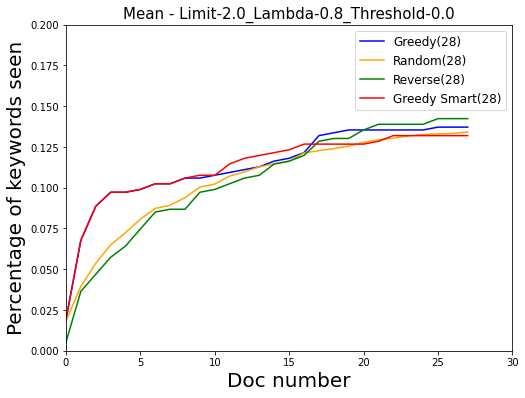

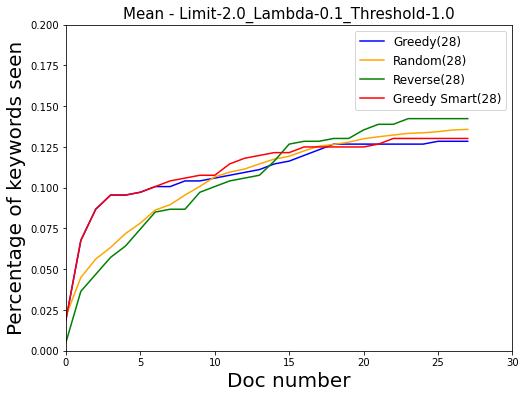

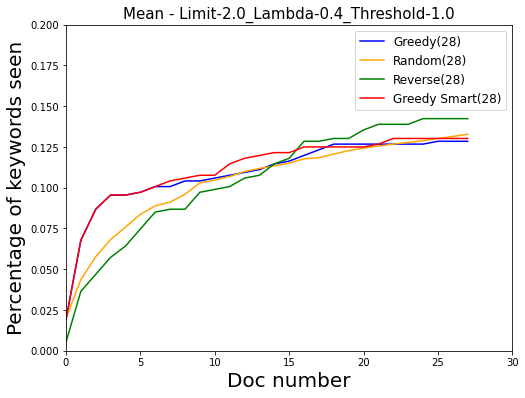

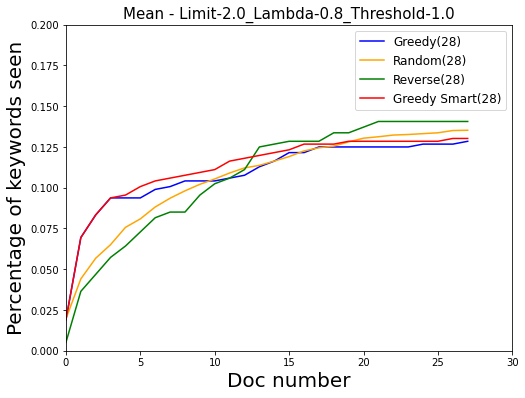

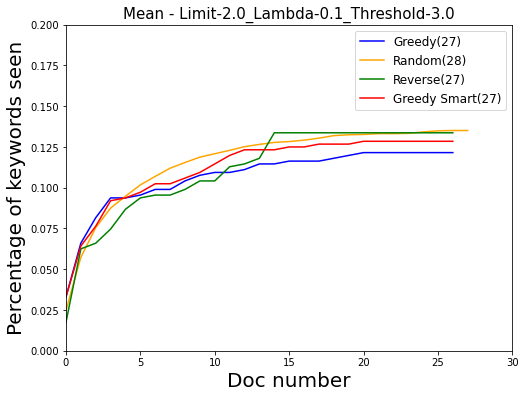

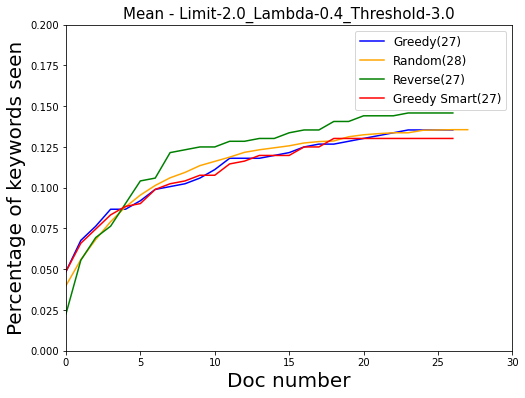

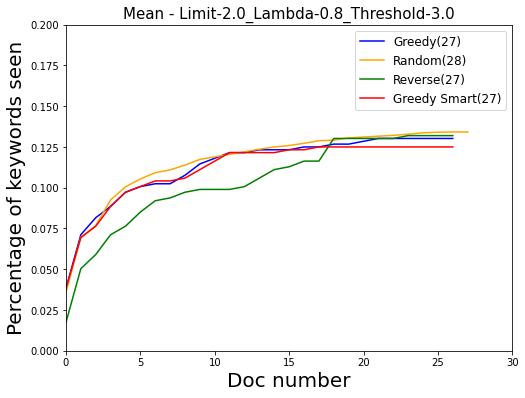

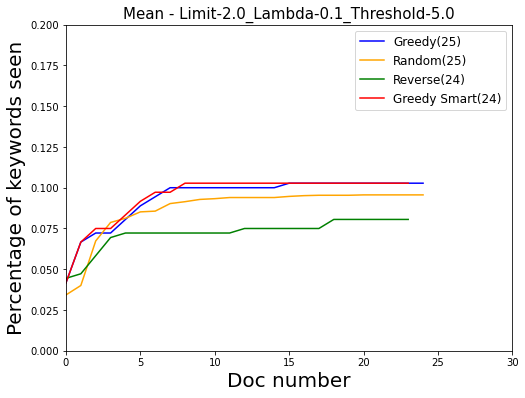

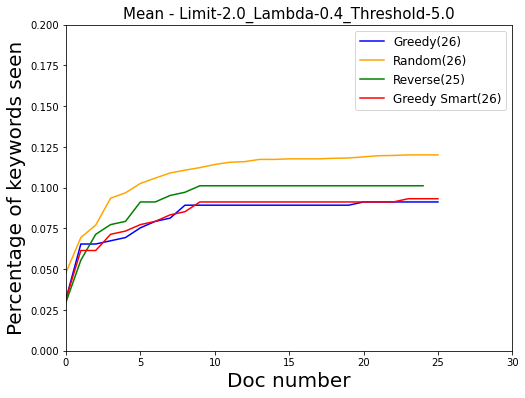

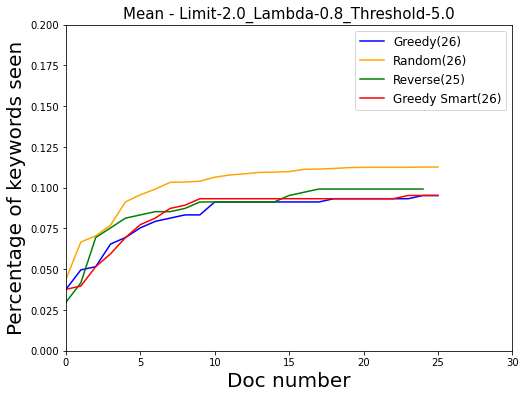

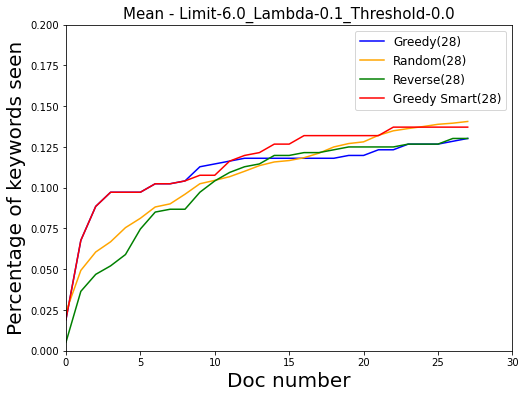

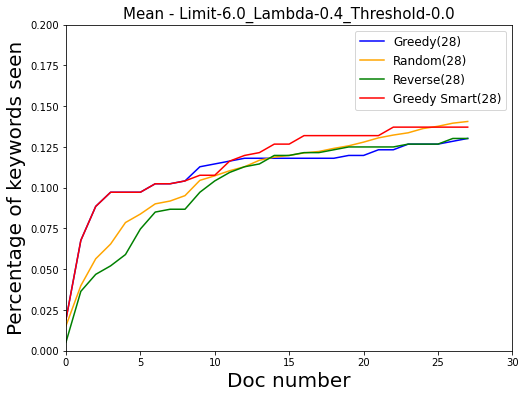

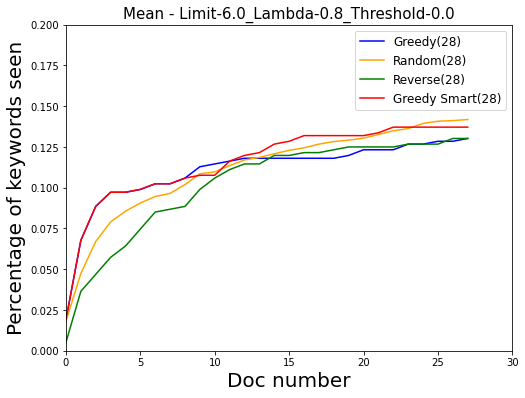

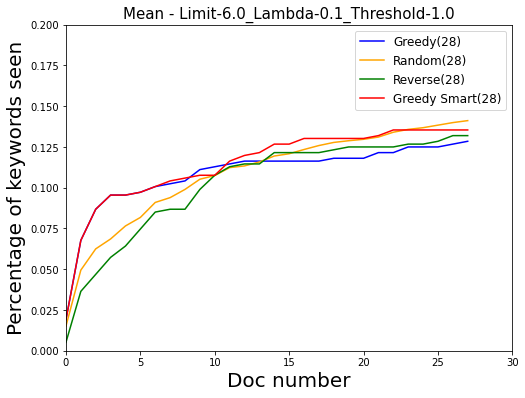

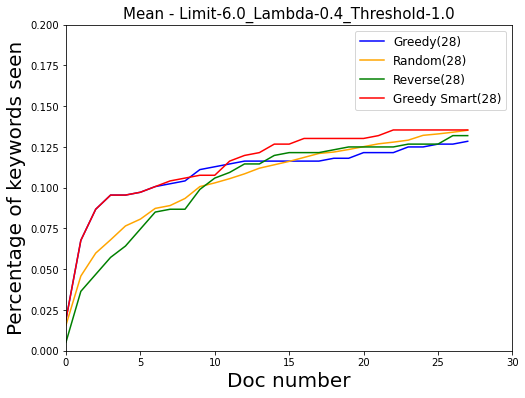

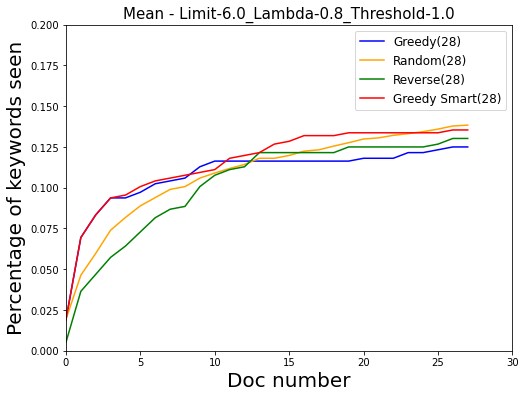

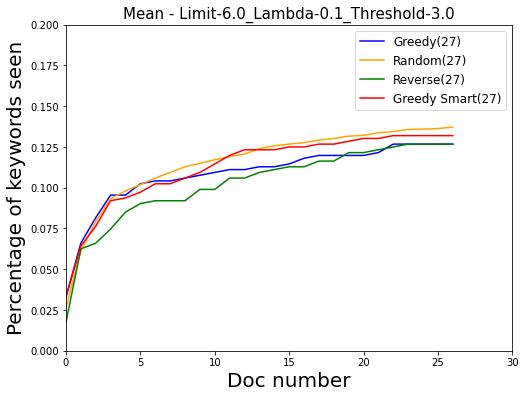

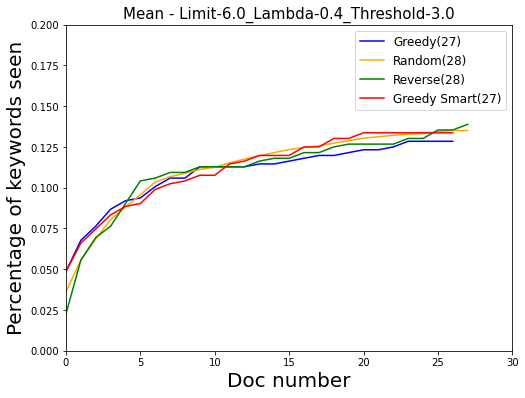

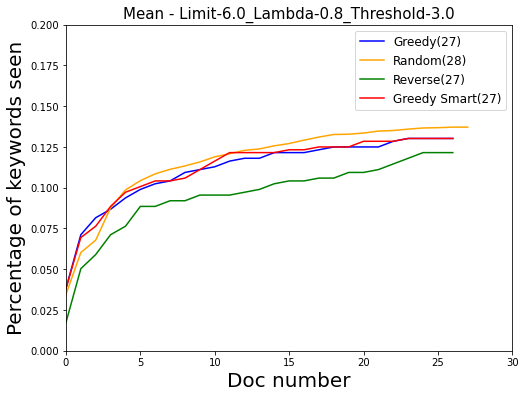

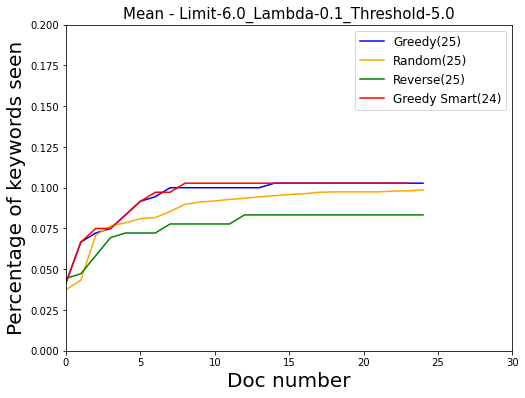

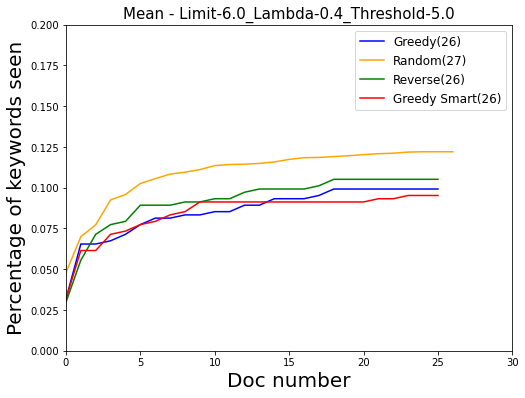

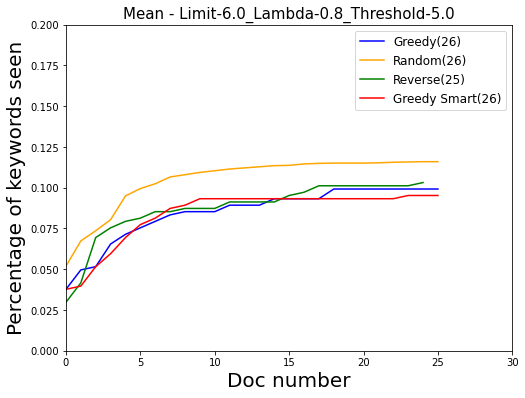

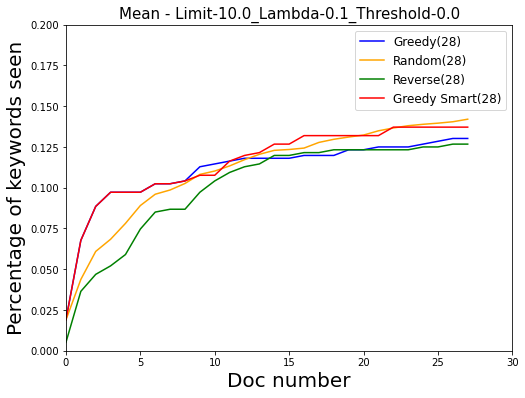

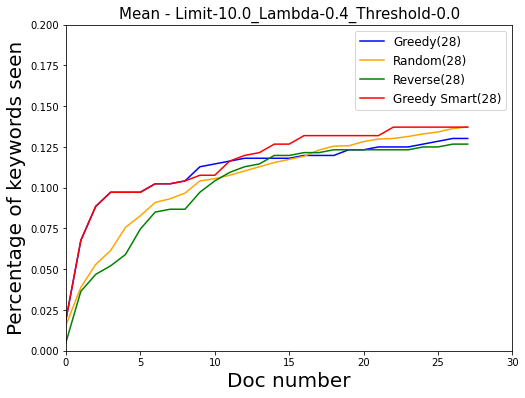

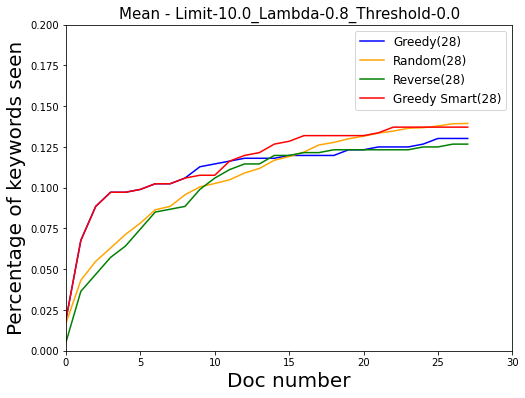

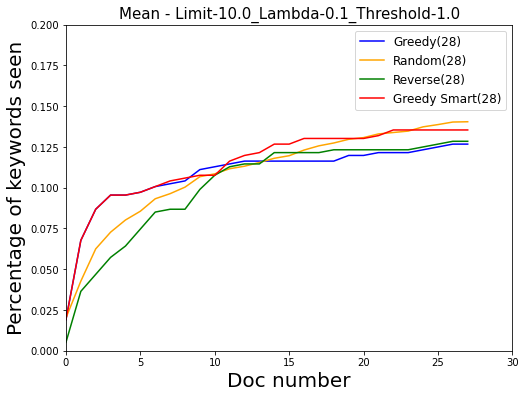

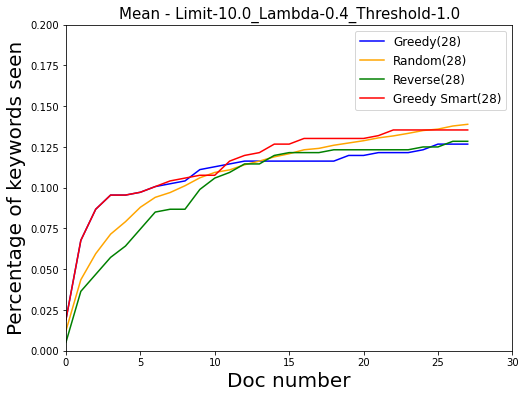

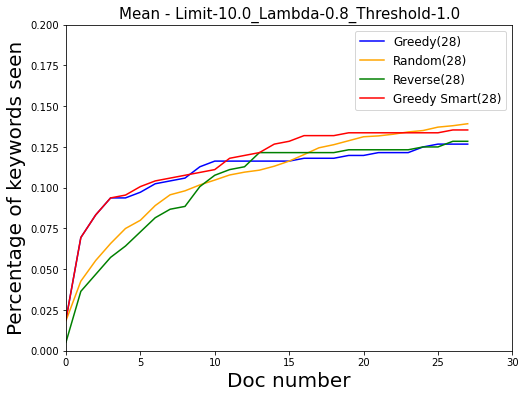

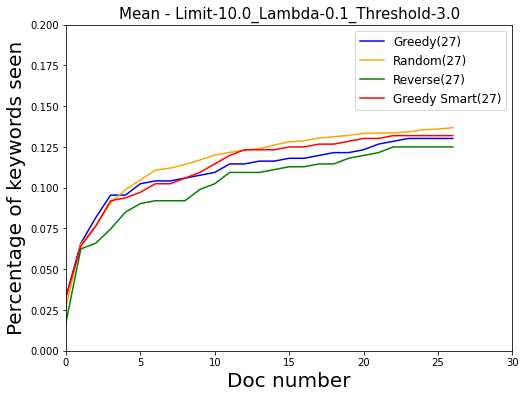

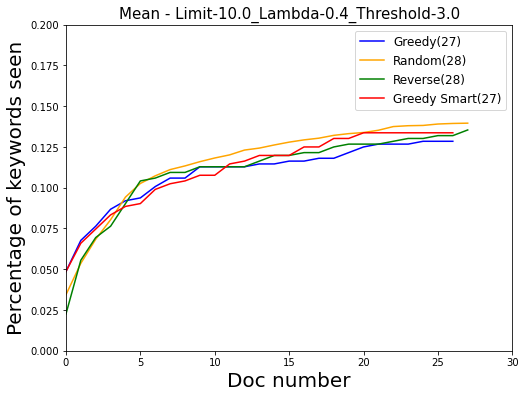

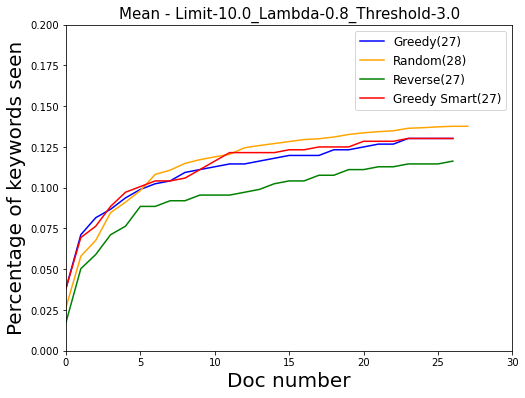

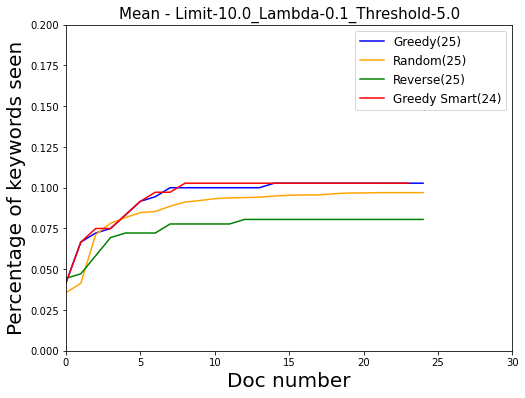

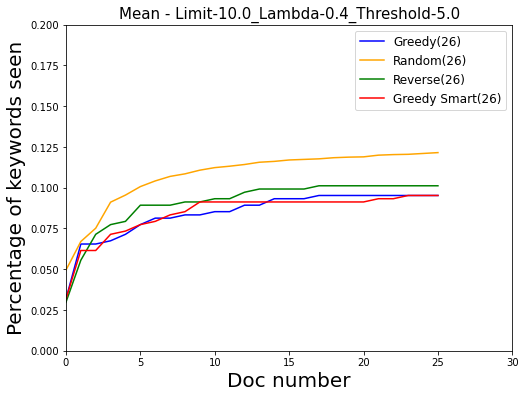

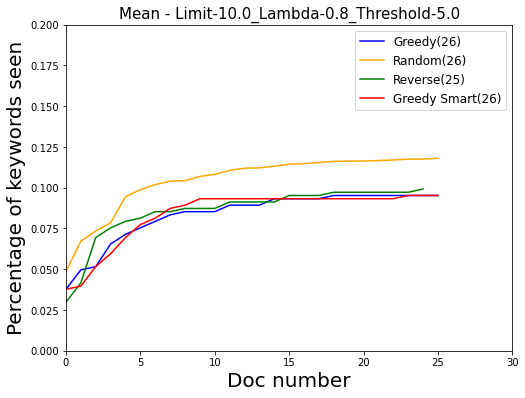

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import product
import numpy as np
import matplotlib.backends.backend_pdf


import urllib
from collections import defaultdict



subtopic = "GLOBAL"


colors = {"Greedy": "blue", "Random": "orange", "Reverse": "green", "GreedySmart": "red"}
    
doc_lambda= 0.1 #FIXED


min_count = 10

all_mean_results = defaultdict(lambda:{})

for idx, (limit, threshold, lam) in tqdm(enumerate(all_users), total=len(all_users)):
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"plots/keywords/Limit-{limit}_Lambda-{lam}_Threshold-{threshold}.pdf")
    all_ys = defaultdict(lambda:defaultdict(lambda:[]))
    for topic in subtopics.keys():
        fig = figure(figsize=(8, 6))
        for method in subtopic_strategies.keys():
            method_id = subtopic_strategies[method]
            y_values = percentage_of_keywords_per_doc(limit, lam, threshold, topic, method,  10)
            x_values = list(range(len(y_values)))
            all_ys[method][topic]=y_values
            plt.plot(x_values, y_values, label=" ".join(camel_case_split(method))+f"({len(y_values)-1})", c=colors[method])
            plt.axvline(x=len(y_values)-1,linestyle=":", c=colors[method], alpha=0.7)
        plt.xlabel(f"Doc number", fontsize=20)
        plt.title(topic, fontsize=15)
        plt.ylabel("Percentage of keywords seen", fontsize=20)
        plt.legend(fontsize=12)
        pdf.savefig(fig)
        plt.close()
    # Mean plots
    fig = figure(figsize=(8, 6))
    for method in all_ys:            
        longest_session = max(map(len, all_ys[method].values()))
        for topic in all_ys[method]:
            try:
                padding_needed = longest_session - len(all_ys[method][topic])
                padding = [all_ys[method][topic][-1]] * padding_needed
                all_ys[method][topic] += padding
            except:
                continue    
        # For this method, for each query number (longest_session), multiply by the respective normalization factor and take the mean
        mean_ys = []
        for i in range(longest_session):
            session_ys = []
            for topic in all_ys[method]:
                try:
                    session_ys.append(all_ys[method][topic][i]*normalization_factors[topic])
                except:
                    continue
            mean_ys.append(np.mean(session_ys))
        plt.plot(range(longest_session), mean_ys, label=" ".join(camel_case_split(method))+f"({len(mean_ys)})", c=colors[method])
        u_id = f"Limit-{limit}_Lambda-{lam}_Threshold-{threshold}"
        all_mean_results[u_id][method] = mean_ys
    plt.xlabel(f"Doc number", fontsize=20)
    plt.title(f"Mean - Limit-{limit}_Lambda-{lam}_Threshold-{threshold}", fontsize=15)
    plt.ylabel("Percentage of keywords seen", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlim(0, 30)
    plt.ylim(0, 0.2)
    plt.show()
    pdf.savefig(fig)
    plt.savefig(f"plots/raw/Limit-{limit}_Lambda-{lam}_Threshold-{threshold}.svg")
    plt.close() 
    pdf.close()
